In [2]:
import os
# Allow duplicate OpenMP runtimes so torch won’t segfault
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
print("Set KMP_DUPLICATE_LIB_OK =", os.environ["KMP_DUPLICATE_LIB_OK"])


Set KMP_DUPLICATE_LIB_OK = TRUE


In [1]:
import os, pprint

root = 'dataset/video2'
for sub in ['train/images', 'train/labels', 'valid/images', 'valid/labels', 'test/images']:
    path = os.path.join(root, sub)
    print(path, "→", "EXISTS" if os.path.isdir(path) else "MISSING", "/", 
          len(os.listdir(path)) if os.path.isdir(path) else "")


dataset/video2\train/images → EXISTS / 1045
dataset/video2\train/labels → EXISTS / 1046
dataset/video2\valid/images → EXISTS / 98
dataset/video2\valid/labels → EXISTS / 98
dataset/video2\test/images → EXISTS / 79


In [4]:
import glob, os

base = 'dataset/video2'
splits = ['train', 'valid', 'test']

for split in splits:
    lbl_dir = f'{base}/{split}/labels'
    for path in glob.glob(os.path.join(lbl_dir, '*.txt')):
        lines = []
        with open(path) as f:
            for line in f:
                parts = line.strip().split()
                if not parts:
                    continue
                # only keep original class 0 (cars) and map it to 2
                # if your old labels never use 1, the others will be discarded
                if parts[0] == '0':
                    parts[0] = '2'
                    lines.append(' '.join(parts))
        # overwrite file with only new '2' lines
        with open(path, 'w') as f:
            f.write('\n'.join(lines))
    print(f'→ Processed {split} labels, {len(glob.glob(lbl_dir+"/*.txt"))} files.')


→ Processed train labels, 1045 files.
→ Processed valid labels, 98 files.
→ Processed test labels, 79 files.


In [10]:
# train_cars_cosine.py
from ultralytics import YOLO
import os

# ─── 1. Paths & run settings ───────────────────────────────────────────────────────────
DATA_YAML   = 'dataset/video2/data.yaml'       # your single-class YAML
PRETRAINED  = 'outputs/cars_cosine_run2/weights/best.pt'            # COCO-pretrained weights
PROJECT     = 'outputs2'
RUN_NAME    = 'train2'                # output folder name

# ─── 2. Hyperparameters & schedules ────────────────────────────────────────────────────
EPOCHS        = 100
BATCH_SIZE    = 8
IMGSZ         = 640

OPTIMIZER     = 'AdamW'
LR0           = 0.0005      # initial LR
LRF           = 0.01        # final LR = LR0 * LRF (cosine decay)
WARMUP_EPOCHS = 3

WEIGHT_DECAY   = 0.0005
DROPOUT        = 0.2         # dropout in detection head

LABEL_SMOOTHING = 0.1        # optional

PATIENCE     = 10            # early stopping
DEVICE       = 0             # GPU 0
SINGLE_CLS   = True          # treat your one class as idx=0

# ─── 3. Load model & inject dropout ───────────────────────────────────────────────────
model = YOLO(PRETRAINED)
# inject dropout into YOLOv11n's Detect head
model.model.model[-1].m = DROPOUT

# ─── 4. Train (no augmentations) ──────────────────────────────────────────────────────
model.train(
    data            = DATA_YAML,
    epochs          = EPOCHS,
    batch           = BATCH_SIZE,
    imgsz           = IMGSZ,
    optimizer       = OPTIMIZER,
    lr0             = LR0,
    lrf             = LRF,
    warmup_epochs   = WARMUP_EPOCHS,
    weight_decay    = WEIGHT_DECAY,
    dropout         = DROPOUT,
    label_smoothing = LABEL_SMOOTHING,
    device          = DEVICE,
    patience        = PATIENCE,
    single_cls      = SINGLE_CLS,
    project         = PROJECT,
    name            = RUN_NAME,
    save_period     = 0      # only best.pt & last.pt
)

# ─── 5. Prune extra checkpoints ────────────────────────────────────────────────────────
weights_dir = f"{PROJECT}/{RUN_NAME}/weights"
if os.path.isdir(weights_dir):
    for f in os.listdir(weights_dir):
        if f not in ('best.pt', 'last.pt'):
            os.remove(os.path.join(weights_dir, f))
    print(f"✅ Kept only best.pt & last.pt in {weights_dir}")
else:
    print(f"⚠️  Weights directory not found: {weights_dir}")


New https://pypi.org/project/ultralytics/8.3.157 available  Update with 'pip install -U ultralytics'
WARNING 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.156  Python-3.9.23 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/video2/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.2, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=outputs/cars_cosine_run2/weights/bes

train: Scanning C:\Users\Himanshu\Desktop\yolov11n\dataset\video2\train\labels.cache... 1045 images, 506 backgrounds, 0


val: Fast image access  (ping: 0.00.0 ms, read: 1364.5688.2 MB/s, size: 69.2 KB)


val: Scanning C:\Users\Himanshu\Desktop\yolov11n\dataset\video2\valid\labels.cache... 98 images, 52 backgrounds, 0 corr


Plotting labels to outputs2\train22\labels.jpg... 
optimizer: AdamW(lr=0.0005, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to outputs2\train22
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.21G      1.482      1.118      1.088          8        640: 100%|██████████| 131/131 [00:08<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<0

                   all         98         90      0.837      0.799      0.856      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.21G      1.387      1.012      1.037          3        640: 100%|██████████| 131/131 [00:06<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<0

                   all         98         90      0.868      0.833      0.892      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.21G      1.336     0.9402     0.9945          5        640: 100%|██████████| 131/131 [00:06<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<0

                   all         98         90      0.894      0.848      0.942       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.21G      1.283     0.8537     0.9955          4        640: 100%|██████████| 131/131 [00:06<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<0

                   all         98         90      0.916      0.849      0.927      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.21G      1.338      0.945      1.007          3        640: 100%|██████████| 131/131 [00:06<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<0

                   all         98         90      0.931      0.789      0.919      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.21G      1.199     0.8462     0.9877          5        640: 100%|██████████| 131/131 [00:06<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<0

                   all         98         90      0.796      0.922       0.93      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.21G      1.203     0.8257     0.9663          1        640: 100%|██████████| 131/131 [00:06<00:00, 2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<0

                   all         98         90      0.757      0.811      0.863      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.21G       1.18     0.8224     0.9479          5        640: 100%|██████████| 131/131 [00:06<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<0

                   all         98         90      0.779      0.867      0.898       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.21G      1.126     0.8794     0.9709         10        640: 100%|██████████| 131/131 [00:06<00:00, 2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<0

                   all         98         90      0.796      0.869      0.905      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.21G      1.157     0.8305     0.9634          5        640: 100%|██████████| 131/131 [00:06<00:00, 2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<0


                   all         98         90      0.795      0.889      0.922      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.21G       1.13     0.7803     0.9604          7        640: 100%|██████████| 131/131 [00:06<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<0

                   all         98         90      0.843      0.878       0.92      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.21G      1.149     0.7996     0.9758          1        640: 100%|██████████| 131/131 [00:06<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<0

                   all         98         90      0.832      0.889      0.937      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.21G      1.121     0.7374     0.9161          6        640: 100%|██████████| 131/131 [00:06<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<0

                   all         98         90      0.838      0.889      0.937      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.21G      1.133     0.7667     0.9703          8        640: 100%|██████████| 131/131 [00:06<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<0

                   all         98         90      0.794      0.941      0.932      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.21G      1.088     0.7454     0.9501          5        640: 100%|██████████| 131/131 [00:06<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<0

                   all         98         90       0.88      0.818      0.923      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.21G      1.075      0.778     0.9329          5        640: 100%|██████████| 131/131 [00:06<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<0

                   all         98         90      0.858      0.822      0.915       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.22G      1.137     0.7073     0.9457          8        640: 100%|██████████| 131/131 [00:06<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<0

                   all         98         90      0.794      0.898      0.934      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.22G      1.143      0.718     0.9549          6        640: 100%|██████████| 131/131 [00:06<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<0

                   all         98         90      0.868      0.822      0.894      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.22G      1.087     0.7133     0.9464          2        640: 100%|██████████| 131/131 [00:06<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<0

                   all         98         90      0.906      0.822      0.922      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.22G      1.105     0.7513     0.9467         10        640: 100%|██████████| 131/131 [00:06<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<0

                   all         98         90      0.941      0.713      0.865      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.22G      1.054     0.7317     0.9315          5        640: 100%|██████████| 131/131 [00:06<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<0

                   all         98         90      0.851      0.889      0.934      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.22G      1.014     0.6887     0.9138          7        640: 100%|██████████| 131/131 [00:06<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<0

                   all         98         90      0.922      0.811      0.926      0.652
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 12, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

22 epochs completed in 0.044 hours.


Optimizer stripped from outputs2\train22\weights\last.pt, 5.5MB
Optimizer stripped from outputs2\train22\weights\best.pt, 5.5MB

Validating outputs2\train22\weights\best.pt...
Ultralytics 8.3.156  Python-3.9.23 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<0


                   all         98         90      0.831      0.889      0.937      0.693
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to outputs2\train22
✅ Kept only best.pt & last.pt in outputs2/train2/weights



image 1/1 C:\Users\Himanshu\Desktop\yolov11n\dataset\video1\test\images\vid1_mp4-0130_jpg.rf.786a8acec1bd7cf379e17b995fd16eb6.jpg: 640x640 3 items, 12.9ms
Speed: 2.1ms preprocess, 12.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


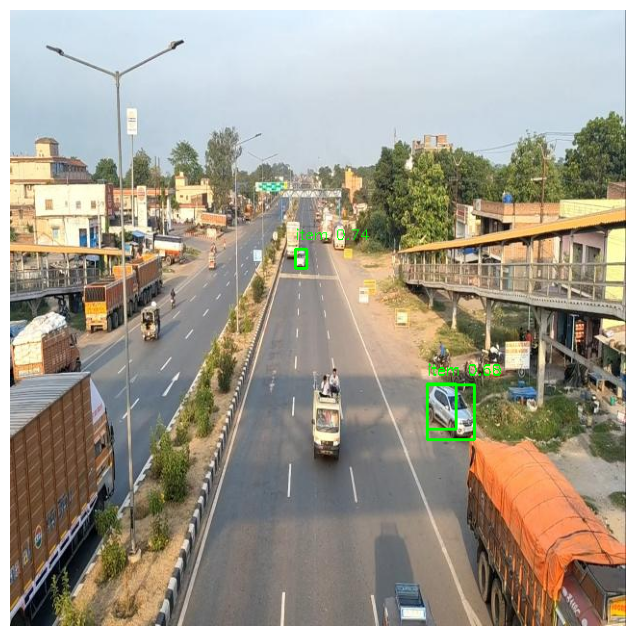

In [11]:
# Make sure figures show up inline in Jupyter
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load the trained model
model = YOLO('outputs2/train22/weights/best.pt')

# Path to your test image
image_path = 'dataset/video1/test/images/vid1_mp4-0130_jpg.rf.786a8acec1bd7cf379e17b995fd16eb6.jpg'

# Run inference
results = model(image_path, conf=0.3)[0]

# Read image with OpenCV
img = cv2.imread(image_path)

# Draw boxes
for box in results.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
    cls  = int(box.cls.cpu().numpy().item())
    conf = float(box.conf.cpu().numpy().item())
    label = f"{model.names[cls]} {conf:.2f}"

    cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
    cv2.putText(img, label, (x1, y1-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

# Convert BGR→RGB and display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,8))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()


In [12]:
# 1. Run validation on your test partition
res = model.val(
    data='dataset/video2/data.yaml',  # points at train/val/test splits
    split='test',                     # explicitly evaluate on test set
    imgsz=640,                        # same size you trained with
    batch=8,                          # any reasonable batch size
    plots=True                        # generate PR curve & confusion matrix
)


Ultralytics 8.3.156  Python-3.9.23 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
val: Fast image access  (ping: 0.00.0 ms, read: 1609.7358.2 MB/s, size: 70.3 KB)


val: Scanning C:\Users\Himanshu\Desktop\yolov11n\dataset\video2\test\labels.cache... 79 images, 40 backgrounds, 0 corru
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01


                   all         79         56      0.745      0.836      0.838      0.593
Speed: 1.0ms preprocess, 3.9ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\val4


In [13]:
import pandas as pd

# After running `res = model.val(...)`, you have:
#  res.box.p        → Precision
#  res.box.r        → Recall
#  res.box.map50    → mAP@0.50
#  res.box.map      → mAP@0.50–0.95
#  res.box.f1       → F1 Score

# Build a table of those values:
metric_names = ['Precision', 'Recall', 'mAP@0.50', 'mAP@0.50:0.95', 'F1 Score']
metric_values = [
    res.box.p,
    res.box.r,
    res.box.map50,
    res.box.map,
    res.box.f1
]

df = pd.DataFrame({'Metric': metric_names, 'Value': metric_values})
display(df)


,Metric,Value
0,Precision,[0.7452519246574326]
1,Recall,[0.8358861804820669]
2,mAP@0.50,0.837503
3,mAP@0.50:0.95,0.592822
4,F1 Score,[0.7879713767872917]
